<a href="https://colab.research.google.com/github/microsoft/FLAML/blob/main/notebook/autogen_agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

FLAML offers an experimental feature of interactive LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/FLAML/docs/Use-Cases/Auto-Generation#agents-experimental).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

FLAML requires `Python>=3.8`. To run this notebook example, please install flaml with the [autogen] option:
```bash
pip install flaml[autogen]
```

In [1]:
# %pip install flaml[autogen]~=2.0.0rc4

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/FLAML/docs/reference/autogen/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [2]:
from flaml import oai

config_list = oai.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt4", "gpt-4-32k", "gpt-4-32k-0314"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choose "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in FLAML to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [3]:
from flaml.autogen.agentchat import AssistantAgent, UserProxyAgent

# create an AssistantAgent named "assistant"
assistant = AssistantAgent(
    name="assistant",
    oai_config={
        "seed": 42,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for flaml.oai, an enhanced inference API compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

# filename: stock_comparison.py
```python
import datetime
import yfinance as yf

# Get today's date
today = datetime.date.today()
print("Today's date:", today)

# Get the start of the year
start_of_year = datetime.date(today.year, 1, 1)

# Download the historical data for META and TESLA
meta_data = yf.download('META', start=start_of_year, end=today)
tesla_data = yf.download('TSLA', start=start_of_year, end=today)

# Calculate the year-to-date gain for META and TESLA
meta_gain = (meta_data['Close'][-1] - meta_data['Close'][0]) / meta_data['Close'][0]
tesla_gain = (tesla_data['Close'][-1] - tesla_data['Close'][0]) / tesla_data['Close'][0]

# Print the year-to-date gain for META and TESLA
print("Year-to-date gain for META:", round(meta_gain * 100, 2), "%")
print("Year-to-date gain for

user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
Today's date: 2023-07-26
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Year-to-date gain for META: 136.07 %
Year-to-date gain for TESLA: 145.4 %


--------------------------------------------------------------------------------
assistant (to user_proxy):

Great! The code executed successfully. Today's date is July 26, 2023. The year-to-date gain for META is 136.07%, and the year-to-date gain for TESLA is 145.4%. Please let me know if you need any further assistance.

TERMINATE

--------------------------------------------------------------------------------


The example above involves code execution. In FLAML, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, FLAML defaults to the `flaml/autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto generated.

## Example Task: Plot Chart

In [4]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

# filename: stock_price_chart.py
```python
import datetime
import yfinance as yf
import matplotlib.pyplot as plt

# Get today's date
today = datetime.date.today()

# Get the start of the year
start_of_year = datetime.date(today.year, 1, 1)

# Download the historical data for META and TESLA
meta_data = yf.download('META', start=start_of_year, end=today)
tesla_data = yf.download('TSLA', start=start_of_year, end=today)

# Plot the stock price change YTD for META and TESLA
plt.figure(figsize=(10, 6))
plt.plot(meta_data['Close'], label='META')
plt.plot(tesla_data['Close'], label='TSLA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Change YTD for META and TESLA')
plt.legend()

# Save the chart to stock_price_ytd.png
plt.savefig('stock_price_ytd.png')
plt.sh

Let's display the generated figure.

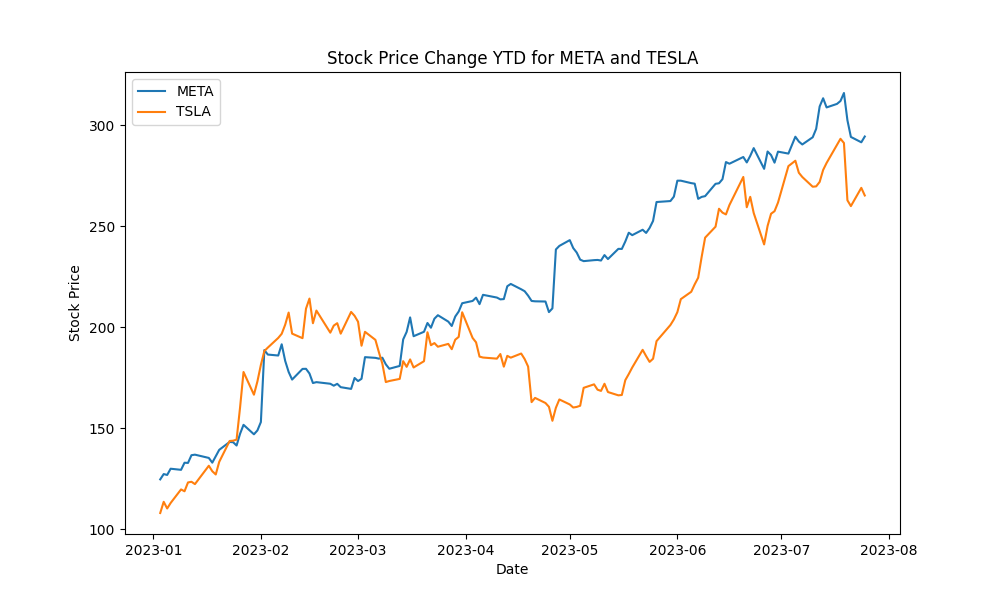

In [5]:
from IPython.display import Image

Image(filename='coding/stock_price_ytd.png')

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [6]:
from typing import Dict, Union
from IPython import get_ipython

class IPythonUserProxyAgent(UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return super().generate_init_message(*args, **kwargs) + """
If you suggest code, the code will be executed in IPython."""

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell(code)
        log = str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, bytes(log, "utf-8"), None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display plot directly.

ipython_user_proxy (to assistant):

Plot a chart of META and TESLA stock price change YTD
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

Sure, we can use the `yfinance` library in Python to download the stock price data and `matplotlib` to plot the data. If you don't have `yfinance` installed, you can install it using pip:

```python
!pip install yfinance
```

Here is the Python code to plot the YTD stock price change for META (Facebook) and TESLA.

```python
# Python code
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# Define the ticker symbol
tickerSymbols = ['META', 'TSLA']

# Get data on this ticker
start_date = datetime(datetime.now().year, 1, 1)
end_date = datetime.now()

# Fetch the data
data = yf.download(tickerSymbols, start=start_date, end=end_date)

# Plot the close prices
plt.figure(figsize=(14,7))
plt.plot(

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
[*********************100%***********************]  2 of 2 completed


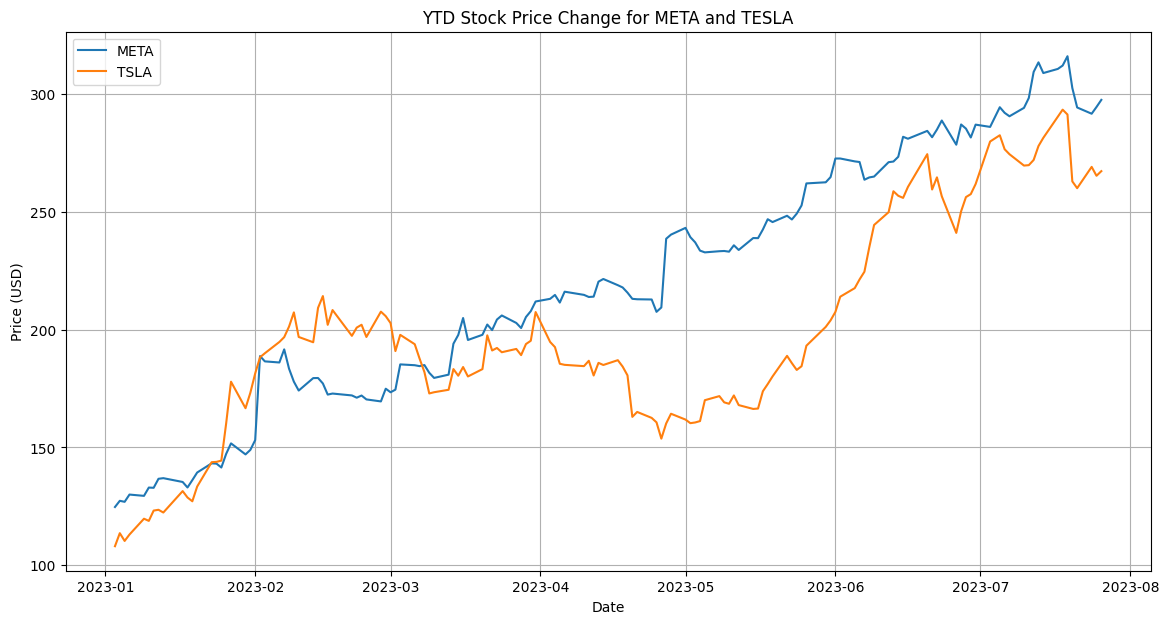

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
None
None

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

It seems like the code executed successfully but didn't produce any output. This could be due to the fact that the IPython environment you're using might not support matplotlib's interactive mode. 

Let's try a different approach using pandas' built-in plotting function, which should work in any environment. 

```python
# Python code
import yfinance as yf
import pandas as pd
from datetime import datetime

# Define the ticker symbol
tickerSymbols = ['META', 'TSLA']

# Get data on this ticker
start_date = datetime(datetime.now().year, 1, 1)
end_date = datetime.now()

# Fetch the data
data = yf.download(tickerSymbols, start=start_date, end=end_date)

# Plot the close prices
data['Close'].plot(title='YTD Stock Price Change for META and TESLA', figsize=(14,7), grid=True)
```

This c

<Axes: title={'center': 'YTD Stock Price Change for META and TESLA'}, xlabel='Date'>

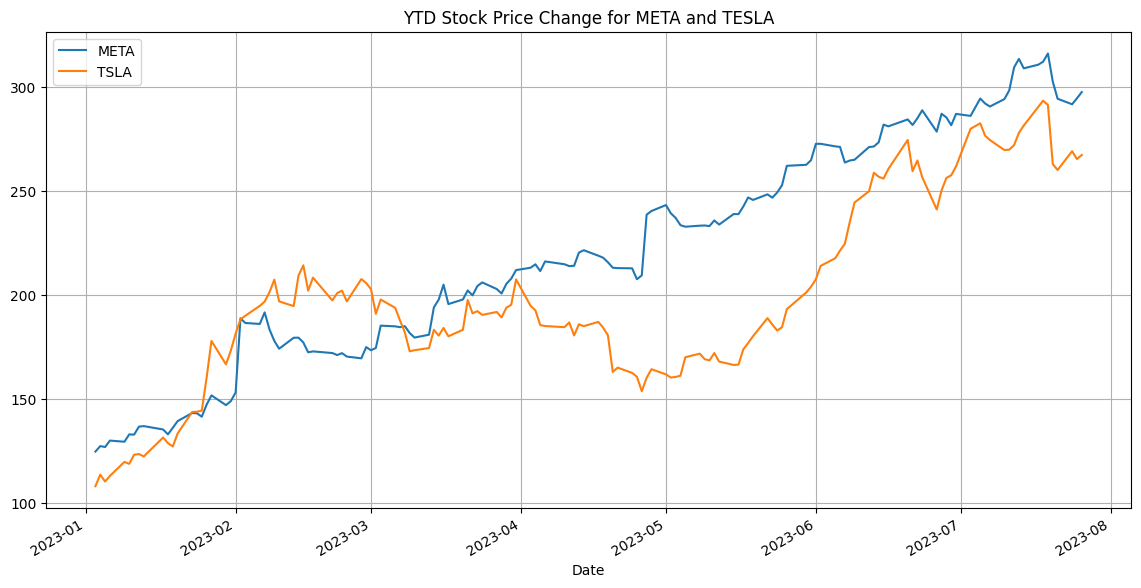

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
Axes(0.125,0.2;0.775x0.68)

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

Great! The code executed successfully. The output `Axes(0.125,0.2;0.775x0.68)` is just a representation of the plot object. The actual plot should be displayed in your IPython environment. 

The plot should show the YTD stock price change for META and TESLA. The x-axis represents the date and the y-axis represents the closing price in USD. 

If you can see the plot and it meets your requirements, then we are done here. 

TERMINATE

--------------------------------------------------------------------------------


In [7]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE") or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
assistant.reset()
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of META and TESLA stock price change YTD""",
)